<img src="https://kaggle2.blob.core.windows.net/competitions/kaggle/4467/logos/front_page.png", style="float:left;width:100px;height:50px;">

In [1]:
# 기본 tool
import pandas as pd 
import numpy as np
import time
#시각화
from matplotlib import pyplot as plt
import seaborn as sns 
%matplotlib inline 

### 1. Data Import

In [2]:
train = pd.read_csv('./input/train_set.csv', parse_dates=[2,]) # parse_datas: 연-월-일로 되어 있는 data를 분리하기 위해 
test = pd.read_csv('./input/test_set.csv', parse_dates=[3,])
tube_data = pd.read_csv('./input/tube.csv')
bill_of_materials_data = pd.read_csv('./input/bill_of_materials.csv')
specs_data = pd.read_csv('./input/specs.csv')

### 2. EDA
#### (1) train, test dataset

In [3]:
def info(dataset):
    print("* shape of dataset")
    print(dataset.shape)
    print("------------------------------------------")
    print("* columns:")
    print(dataset.columns)
    print("------------------------------------------")
    print("* brief information of dataframe:")
    print(dataset.info())

In [4]:
info(train)

* shape of dataset
(30213, 8)
------------------------------------------
* columns:
Index(['tube_assembly_id', 'supplier', 'quote_date', 'annual_usage',
       'min_order_quantity', 'bracket_pricing', 'quantity', 'cost'],
      dtype='object')
------------------------------------------
* brief information of dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30213 entries, 0 to 30212
Data columns (total 8 columns):
tube_assembly_id      30213 non-null object
supplier              30213 non-null object
quote_date            30213 non-null datetime64[ns]
annual_usage          30213 non-null int64
min_order_quantity    30213 non-null int64
bracket_pricing       30213 non-null object
quantity              30213 non-null int64
cost                  30213 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 1.8+ MB
None


In [5]:
info(test)

* shape of dataset
(30235, 8)
------------------------------------------
* columns:
Index(['id', 'tube_assembly_id', 'supplier', 'quote_date', 'annual_usage',
       'min_order_quantity', 'bracket_pricing', 'quantity'],
      dtype='object')
------------------------------------------
* brief information of dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30235 entries, 0 to 30234
Data columns (total 8 columns):
id                    30235 non-null int64
tube_assembly_id      30235 non-null object
supplier              30235 non-null object
quote_date            30235 non-null datetime64[ns]
annual_usage          30235 non-null int64
min_order_quantity    30235 non-null int64
bracket_pricing       30235 non-null object
quantity              30235 non-null int64
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 1.8+ MB
None


(train과 test dataset의 차이)
- test dataset의 data 수가 조금 더 많음. (30213 vs 30235)
- test dataset에는 종속변수 price 포함 X, id 포함

Train dataset부터 살펴보자.  
a. category 변수 3개 (tube_assembly_id, supplier, bracket_pricing) 존재한다. 이들 먼저 살펴본다.

In [6]:
train['tube_assembly_id'].value_counts().head()

TA-04788    14
TA-04750    12
TA-00199    10
TA-19094     9
TA-02308     9
Name: tube_assembly_id, dtype: int64

In [7]:
train['tube_assembly_id'].describe() # 8855 종

count        30213
unique        8855
top       TA-04788
freq            14
Name: tube_assembly_id, dtype: object

In [8]:
train['supplier'].value_counts().head()

S-0066    20553
S-0041     3323
S-0072     2317
S-0054      838
S-0026      727
Name: supplier, dtype: int64

In [9]:
train['supplier'].describe() # 공급처는 57개, S-0066의 비중이 큼

count      30213
unique        57
top       S-0066
freq       20553
Name: supplier, dtype: object

In [10]:
train['bracket_pricing'].value_counts() # bracket_pricing이 대부분 (약 7:1), Y or N 로 이산형 변수로 볼 수 있음

Yes    26283
No      3930
Name: bracket_pricing, dtype: int64

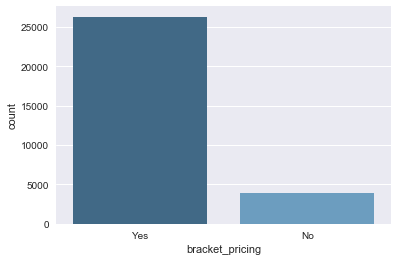

In [11]:
sns.countplot(data=train, x="bracket_pricing", palette="Blues_d")
plt.show()

b. 양적 변수 (예측해야할 종속 변수 cost 포함하여 살펴봄)

In [12]:
train.describe()

,annual_usage,min_order_quantity,quantity,cost
count,30213.000000,30213.000000,30213.000000,30213.000000
mean,120.369377,2.084699,38.389369,13.433317
std,1590.331872,12.742776,70.761392,28.663200
min,0.000000,0.000000,1.000000,0.503553
25%,0.000000,0.000000,2.000000,3.878190
50%,0.000000,0.000000,10.000000,6.521146
75%,2.000000,0.000000,40.000000,13.431781
max,150000.000000,535.000000,2500.000000,1000.000000


In [13]:
quan_col = ["cost", "annual_usage", "min_order_quantity", "quantity"]
train_quan = train[quan_col]
train_quan.head()

,cost,annual_usage,min_order_quantity,quantity
0,21.905933,0,0,1
1,12.341214,0,0,2
2,6.601826,0,0,5
3,4.687770,0,0,10
4,3.541561,0,0,25


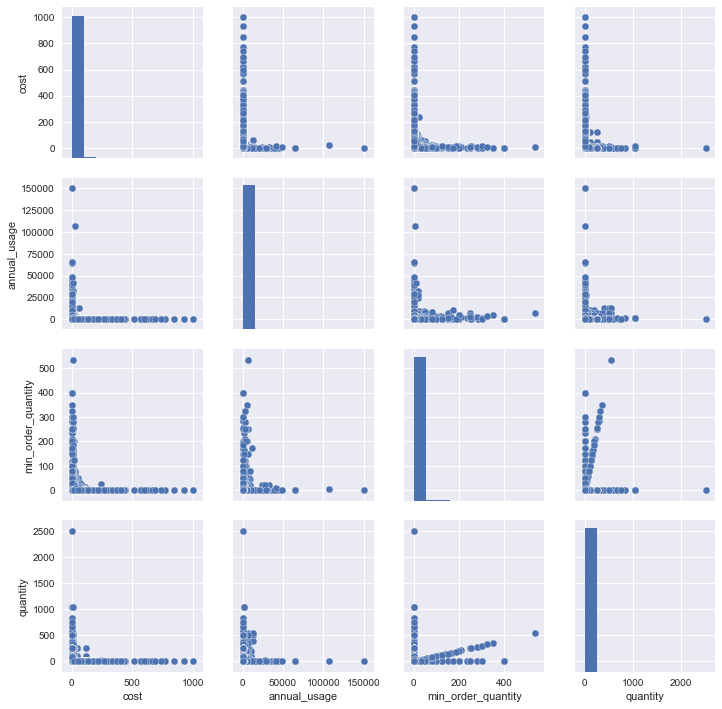

In [14]:
# cost를 비롯한 변수 간의 분포 시각화 - 대부분의 cost는 낮은 값에 몰려있다.
sns.pairplot(train_quan)

c. date 정보

In [15]:
train['quote_date'].describe() # 견적일은 1781 가지

count                   30213
unique                   1781
top       2013-10-01 00:00:00
freq                     2877
first     1982-09-22 00:00:00
last      2017-01-01 00:00:00
Name: quote_date, dtype: object

하루 단위로 특징을 잡기에는 범위가 너무 넓다. -> 연, 월로만 본다면?

In [16]:
# quote_date feature를 각각 year, month, day 정보로 분리하고, quote_date는 drop
train['year'] = train.quote_date.dt.year
train['month'] = train.quote_date.dt.month
train['day'] = train.quote_date.dt.day
train = train.drop(['quote_date'], axis = 1)

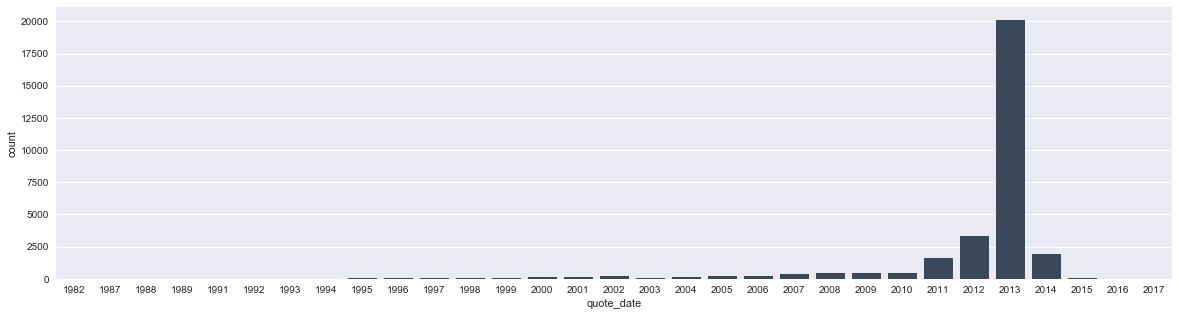

In [17]:
fig,ax = plt.subplots()
fig.set_size_inches(20,5)
sns.countplot(color="#34495e", data=train, x="year", ax=ax)
ax.set(xlabel='quote_date')

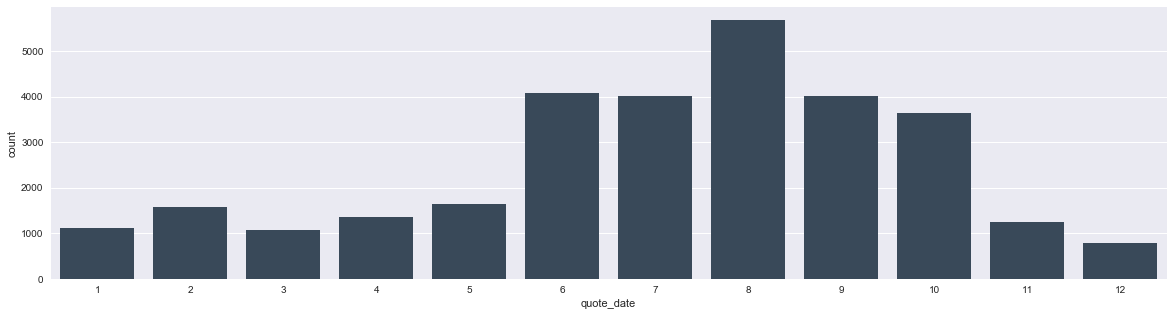

In [18]:
fig,ax = plt.subplots()
fig.set_size_inches(20,5)
sns.countplot(color="#34495e", data=train, x="month", ax=ax)
ax.set(xlabel='quote_date')

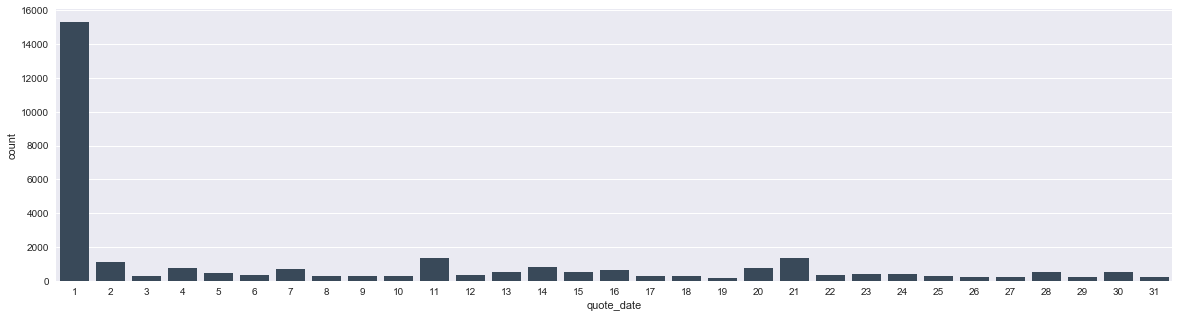

In [19]:
fig,ax = plt.subplots()
fig.set_size_inches(20,5)
sns.countplot(color="#34495e", data=train, x="day", ax=ax)
ax.set(xlabel='quote_date')
# 대부분의 data가 1일에 치중 -> var. 낮다. 통계적으로 의미??

In [20]:
train = train.drop(['day'], axis = 1)

#### (2) tube_data

In [23]:
tube_data.tail()

,tube_assembly_id,material_id,diameter,wall,length,num_bends,bend_radius,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other
21193,TA-21195,SP-0029,25.40,1.65,86.0,2,38.1,N,N,N,N,EF-003,EF-009,0,0,0
21194,TA-21196,SP-0029,34.92,1.65,49.0,2,50.8,Y,Y,N,N,EF-003,EF-017,0,0,0
21195,TA-21197,SP-0029,34.92,1.65,18.0,1,50.8,Y,Y,N,N,EF-003,EF-017,0,0,0
21196,TA-21198,SP-0029,101.60,1.65,63.0,2,101.6,N,Y,N,Y,EF-009,EF-009,0,0,0
21197,TA-21199,SP-0029,101.60,1.65,124.0,3,101.6,N,Y,N,Y,EF-009,EF-009,0,0,0


In [24]:
info(tube_data)

* shape of dataset
(21198, 16)
------------------------------------------
* columns:
Index(['tube_assembly_id', 'material_id', 'diameter', 'wall', 'length',
       'num_bends', 'bend_radius', 'end_a_1x', 'end_a_2x', 'end_x_1x',
       'end_x_2x', 'end_a', 'end_x', 'num_boss', 'num_bracket', 'other'],
      dtype='object')
------------------------------------------
* brief information of dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21198 entries, 0 to 21197
Data columns (total 16 columns):
tube_assembly_id    21198 non-null object
material_id         20919 non-null object
diameter            21198 non-null float64
wall                21198 non-null float64
length              21198 non-null float64
num_bends           21198 non-null int64
bend_radius         21198 non-null float64
end_a_1x            21198 non-null object
end_a_2x            21198 non-null object
end_x_1x            21198 non-null object
end_x_2x            21198 non-null object
end_a               21198

In [25]:
tube_data.describe()

,diameter,wall,length,num_bends,bend_radius,num_boss,num_bracket,other
count,21198.000000,21198.000000,21198.000000,21198.000000,21198.000000,21198.000000,21198.000000,21198.000000
mean,23.687764,1.578402,100.312844,3.748137,49.350767,0.044485,0.006746,0.022644
std,25.396277,0.745749,70.542771,2.265405,196.468480,0.260737,0.100015,0.199676
min,3.180000,0.710000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.520000,0.890000,48.000000,2.000000,19.050000,0.000000,0.000000,0.000000
50%,15.880000,1.650000,86.000000,3.000000,38.100000,0.000000,0.000000,0.000000
75%,25.400000,1.650000,135.000000,5.000000,50.800000,0.000000,0.000000,0.000000
max,203.200000,7.900000,1333.000000,17.000000,9999.000000,5.000000,5.000000,8.000000


length 0, bend_radius 9999 는 이상치로 보임. -> 전처리 필요!

In [26]:
tube_col = ['material_id', 'end_a_1x', 'end_a_2x', 'end_x_1x', 'end_x_2x', 'end_a', 'end_x']
for i in tube_col:
    print('-'*40)
    print(tube_data[i].describe())
    print(tube_data[i].unique())

----------------------------------------
count       20919
unique         19
top       SP-0029
freq        11488
Name: material_id, dtype: object
['SP-0035' 'SP-0019' 'SP-0029' 'SP-0039' 'SP-0046' 'SP-0028' 'SP-0041'
 'SP-0037' 'SP-0008' nan 'SP-0033' 'SP-0038' 'SP-0045' 'SP-0030' 'SP-0031'
 'SP-0048' 'SP-0044' 'SP-0034' 'SP-0032' 'SP-0036']
----------------------------------------
count     21198
unique        2
top           N
freq      20118
Name: end_a_1x, dtype: object
['N' 'Y']
----------------------------------------
count     21198
unique        2
top           N
freq      18015
Name: end_a_2x, dtype: object
['N' 'Y']
----------------------------------------
count     21198
unique        2
top           N
freq      20377
Name: end_x_1x, dtype: object
['N' 'Y']
----------------------------------------
count     21198
unique        2
top           N
freq      18493
Name: end_x_2x, dtype: object
['N' 'Y']
----------------------------------------
count      21198
unique        25
t

In [27]:
tube_data.isnull().sum()
# material_id에 결측값이 존재 -> 후에 전처리 필요!

tube_assembly_id      0
material_id         279
diameter              0
wall                  0
length                0
num_bends             0
bend_radius           0
end_a_1x              0
end_a_2x              0
end_x_1x              0
end_x_2x              0
end_a                 0
end_x                 0
num_boss              0
num_bracket           0
other                 0
dtype: int64

In [28]:
tube_data[tube_data['material_id'].isnull() == True]

,tube_assembly_id,material_id,diameter,wall,length,num_bends,bend_radius,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other
1701,TA-01702,NaN,17.48,2.41,115.0,3,63.50,N,N,N,N,NONE,NONE,0,0,0
2003,TA-02004,NaN,17.30,2.30,30.0,0,0.00,Y,Y,Y,Y,EF-023,NONE,0,0,2
3359,TA-03360,NaN,19.05,2.11,151.0,4,50.80,N,N,N,N,EF-003,EF-003,0,0,0
3895,TA-03896,NaN,6.35,2.26,34.0,4,25.40,N,N,N,N,EF-015,EF-015,0,0,0
4011,TA-04012,NaN,15.88,1.65,182.0,10,38.10,N,N,N,N,EF-003,EF-003,0,0,0
4012,TA-04013,NaN,15.88,1.65,188.0,9,38.10,N,N,N,N,EF-003,EF-003,0,0,0
4013,TA-04014,NaN,15.88,1.65,190.0,7,31.75,N,N,N,N,EF-003,EF-003,0,0,0
4014,TA-04015,NaN,15.88,1.65,181.0,7,31.75,N,N,N,N,EF-003,EF-003,0,0,0
4025,TA-04026,NaN,15.88,1.65,43.0,4,38.10,N,N,N,N,EF-003,EF-003,0,0,0
4026,TA-04027,NaN,15.88,1.65,50.0,2,38.10,N,N,N,N,EF-003,EF-003,0,0,0


#### (4) BOM data
tube assembly를 이루는 componenet의 id와 개수를 알려줌. (comp.는 최대 8가지)

In [29]:
bill_of_materials_data.tail()

,tube_assembly_id,component_id_1,quantity_1,component_id_2,quantity_2,component_id_3,quantity_3,component_id_4,quantity_4,component_id_5,quantity_5,component_id_6,quantity_6,component_id_7,quantity_7,component_id_8,quantity_8
21193,TA-21195,C-1373,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21194,TA-21196,C-1364,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21195,TA-21197,C-1733,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21196,TA-21198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21197,TA-21199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
bom_comp_cols = [col for col in bill_of_materials_data.columns if 'component_id' in col]
for i in bom_comp_cols:
    print('-'*70)
    print(bill_of_materials_data[i].describe())
    print(bill_of_materials_data[i].value_counts())

----------------------------------------------------------------------
count      19149
unique      1079
top       C-1621
freq        2043
Name: component_id_1, dtype: object
C-1621    2043
C-1622    1833
C-1624    1481
C-1623    1414
C-1312    1240
C-1625     950
C-1845     907
C-1620     676
C-1243     620
C-1420     469
C-0448     436
C-0444     219
C-0823     183
C-1642     155
C-1229     155
C-1638     154
C-1639     142
C-1848     138
C-1641     134
C-1626     134
C-1640     127
C-0101     120
C-1629     118
C-1631     117
C-1385      98
C-1637      81
C-1313      80
C-1647      80
C-1649      80
C-1369      78
          ... 
C-0531       1
C-0612       1
C-0229       1
C-1321       1
C-0403       1
C-1942       1
C-1967       1
C-1984       1
C-1966       1
C-1388       1
C-1135       1
C-1975       1
C-0286       1
C-1763       1
C-1973       1
C-1193       1
C-1797       1
C-1370       1
C-1360       1
C-1246       1
C-1183       1
C-0140       1
C-0803       1
C-0428       1


In [31]:
info(bill_of_materials_data)

* shape of dataset
(21198, 17)
------------------------------------------
* columns:
Index(['tube_assembly_id', 'component_id_1', 'quantity_1', 'component_id_2',
       'quantity_2', 'component_id_3', 'quantity_3', 'component_id_4',
       'quantity_4', 'component_id_5', 'quantity_5', 'component_id_6',
       'quantity_6', 'component_id_7', 'quantity_7', 'component_id_8',
       'quantity_8'],
      dtype='object')
------------------------------------------
* brief information of dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21198 entries, 0 to 21197
Data columns (total 17 columns):
tube_assembly_id    21198 non-null object
component_id_1      19149 non-null object
quantity_1          19149 non-null float64
component_id_2      14786 non-null object
quantity_2          14786 non-null float64
component_id_3      4791 non-null object
quantity_3          4798 non-null float64
component_id_4      607 non-null object
quantity_4          608 non-null float64
component_id_5     

In [32]:
bill_of_materials_data.describe()

,quantity_1,quantity_2,quantity_3,quantity_4,quantity_5,quantity_6,quantity_7,quantity_8
count,19149.000000,14786.000000,4798.000000,608.000000,92.000000,26.000000,7.0,1.0
mean,1.559873,1.526106,1.020634,1.027961,1.032609,1.153846,1.0,1.0
std,0.507444,0.510851,0.160100,0.209041,0.178583,0.367946,0.0,NaN
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0
50%,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0
75%,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0
max,6.000000,6.000000,4.000000,4.000000,2.000000,2.000000,1.0,1.0


In [33]:
bom_comp_cols = [col for col in bill_of_materials_data.columns if 'component_id' in col]

In [34]:
bom_comp_df = bill_of_materials_data[bom_comp_cols]

In [35]:
bom_comp_df.describe()

,component_id_1,component_id_2,component_id_3,component_id_4,component_id_5,component_id_6,component_id_7,component_id_8
count,19149,14786,4791,607,92,26,7,1
unique,1079,834,509,204,62,19,4,1
top,C-1621,C-1628,C-1641,C-1660,C-0872,C-0923,C-1019,C-1981
freq,2043,1959,421,62,10,3,3,1


#### (4) Specs data

In [36]:
specs_data.tail()

,tube_assembly_id,spec1,spec2,spec3,spec4,spec5,spec6,spec7,spec8,spec9,spec10
21193,TA-21195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21194,TA-21196,SP-0007,SP-0080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21195,TA-21197,SP-0007,SP-0080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21196,TA-21198,SP-0058,SP-0080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21197,TA-21199,SP-0058,SP-0080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
specs_data.info() # 모두 catergory 형 변수

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21198 entries, 0 to 21197
Data columns (total 11 columns):
tube_assembly_id    21198 non-null object
spec1               7129 non-null object
spec2               6844 non-null object
spec3               5840 non-null object
spec4               4154 non-null object
spec5               2921 non-null object
spec6               2071 non-null object
spec7               535 non-null object
spec8               106 non-null object
spec9               20 non-null object
spec10              1 non-null object
dtypes: object(11)
memory usage: 1.8+ MB


In [38]:
specs_data.describe()

,tube_assembly_id,spec1,spec2,spec3,spec4,spec5,spec6,spec7,spec8,spec9,spec10
count,21198,7129,6844,5840,4154,2921,2071,535,106,20,1
unique,21198,45,51,49,38,37,24,13,4,3,1
top,TA-02916,SP-0007,SP-0012,SP-0080,SP-0026,SP-0080,SP-0082,SP-0082,SP-0082,SP-0088,SP-0080
freq,1,3002,1736,1798,1492,1780,1167,322,73,18,1
